Open CSV then 
- create a _clean copy 
- remove rows that don't have a value in column `predicted_conversion_factor_cm`
- remove images that have an `image_height` less than 3000 
    - this is a limitation of the CF predictor, it significantly overestimates for small images, can fix later
- remove duplicate `component_name` rows
    - if more than one ruler was located, there will be more than one row for the same leaf
    - logic is
        - if only 1 row has a value then keep the row that has `conversion_mean` value 
        - if more than 1 row has a `conversion_mean` value, average them, keep the first row of that component with the averaged `conversion_mean` and delete the other duplicate rows
        - if there are no rows with a `conversion_mean`, just keep the first row


In [99]:
# file_path = "C:/Users/Will/Downloads/herbarium_CF_test/LM2_2024_09_17__15-17-36/Data/Measurements/LM2_2024_09_17__15-17-36_MEASUREMENTS.csv"
# outline_path = "C:/Users/Will/Downloads/herbarium_CF_test/LM2_2024_09_17__15-17-36/Keypoints/Simple_Labels"
# outline_path = "C:/Users/Will/Downloads/herbarium_CF_test/LM2_2024_09_17__15-17-36/Keypoints/Simple_Labels_Original"

file_path = "C:/Users/Will/Downloads/GBIF_DetailedSample_50Spp/LM2_2024_09_18__07-52-47/Data/Measurements/LM2_2024_09_18__07-52-47_MEASUREMENTS.csv"
outline_path = "C:/Users/Will/Downloads/GBIF_DetailedSample_50Spp/LM2_2024_09_18__07-52-47/Keypoints/Simple_Labels"


In [100]:
import pandas as pd

def preprocessing(file_path):
    # Step 1: Load the CSV into a Pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Step 2: Create a copy of the original data for safe cleaning
    df_clean = df.copy()

    # Step 3: Remove rows where 'predicted_conversion_factor_cm' is missing
    df_clean = df_clean.dropna(subset=['predicted_conversion_factor_cm'])

    # Step 4: Remove rows where 'image_height' is less than 3000
    df_clean = df_clean[df_clean['image_height'] >= 3000]

    # Step 5: Handle duplicates in 'component_name'
    def handle_duplicates(group):
        # Filter out rows where conversion_mean is NaN or 0
        valid_conversion_mean = group[(group['conversion_mean'].notna()) & (group['conversion_mean'] != 0)]
        
        # Case 1: If there's only one valid row with a 'conversion_mean', keep that row
        if len(valid_conversion_mean) == 1:
            return valid_conversion_mean
        
        # Case 2: If more than one valid row has 'conversion_mean', average those and keep the first row
        if len(valid_conversion_mean) > 1:
            avg_conversion_mean = valid_conversion_mean['conversion_mean'].mean()
            first_row = group.iloc[0].copy()  # Get a copy of the first row to modify
            first_row['conversion_mean'] = avg_conversion_mean  # Update with the averaged value
            return pd.DataFrame([first_row])  # Return the updated first row as a DataFrame
        
        # Case 3: If no valid rows have 'conversion_mean', just keep the first row of the group
        return group.iloc[[0]]
    
    # Apply the deduplication logic to each group of duplicates in 'component_name'
    df_clean = df_clean.groupby('component_name', group_keys=False).apply(handle_duplicates)

    # Step 6: Return the cleaned DataFrame
    return df_clean


In [101]:
# Usage in Jupyter Notebook
cleaned_df = preprocessing(file_path)

# Display the cleaned data (first 5 rows) to check
print(cleaned_df.head())

# Show the number of rows in the cleaned DataFrame
print(f"Number of rows after cleaning: {cleaned_df.shape[0]}")

                                             filename  image_height  \
10  ANHC_3435785516_Altingiaceae_Liquidambar_styra...          4000   
16  ANHC_3435785516_Altingiaceae_Liquidambar_styra...          4000   
3   ANHC_3435785516_Altingiaceae_Liquidambar_styra...          4000   
1   ANHC_3435785516_Altingiaceae_Liquidambar_styra...          4000   
20  ANHC_3435785516_Altingiaceae_Liquidambar_styra...          4000   

    image_width                                     component_name  \
10         2667  ANHC_3435785516_Altingiaceae_Liquidambar_styra...   
16         2667  ANHC_3435785516_Altingiaceae_Liquidambar_styra...   
3          2667  ANHC_3435785516_Altingiaceae_Liquidambar_styra...   
1          2667  ANHC_3435785516_Altingiaceae_Liquidambar_styra...   
20         2667  ANHC_3435785516_Altingiaceae_Liquidambar_styra...   

    conversion_mean  predicted_conversion_factor_cm   area  perimeter  \
10              0.0                       96.822243  12.71       0.19   
16    

C:\Users\Will\AppData\Local\Temp\ipykernel_79692\2911864284.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby('component_name', group_keys=False).apply(handle_duplicates)


Add helper columns
- split up `component_name` by "__" first
        TI_2005765760_Urticaceae_Pilea_pumila__L__1092-482-1285-855
    - becomes
        variable "to_split", will use in a moment: TI_2005765760_Urticaceae_Pilea_pumila
        column `component_type`: L
        column `component_id`: 1092-482-1285-855
    - then with "to_split" split by "_":
        column `herb`: to_split[0]
        column `gbif_id`: to_split[1]
        column `fullname`: to_split[2] + to_split[3] + to_split[4]
        column `genus_species`: to_split[3] + to_split[4]
        column `family`: to_split[2]
        column `genus`: to_split[3]
        column `specific_epithet`: to_split[4]
- conversion factor error
    - if both values are present, calcualte the error (the calculated `conversion_mean` could still be wrong though)

In [102]:
def add_helper_columns(df):
    # Step 1: Split 'component_name' by "__" first
    split_component = df['component_name'].str.split("__", expand=True)
    
    # The first part before "__" will be the variable "to_split"
    df['to_split'] = split_component[0]
    
    # 'component_type' and 'component_id' come from the second part of the split
    df['component_type'] = split_component[1]
    df['component_id'] = split_component[2]
    
    # Step 2: Split "to_split" further by "_"
    split_to_split = df['to_split'].str.split("_", expand=True)

    # Assigning new columns based on the parsed parts
    df['herb'] = split_to_split[0]
    df['gbif_id'] = split_to_split[1]
    df['fullname'] = split_to_split[2] + "_" + split_to_split[3] + "_" + split_to_split[4]
    df['genus_species'] = split_to_split[3] + "_" + split_to_split[4]
    df['family'] = split_to_split[2]
    df['genus'] = split_to_split[3]
    df['specific_epithet'] = split_to_split[4]

    # Return the DataFrame with the new columns added
    return df

def add_cf_error_column(df):
    # Step to compute cf_error similar to the Excel formula
    df['cf_error'] = df.apply(lambda row: "" if (1 - (row['conversion_mean'] / row['predicted_conversion_factor_cm']) == 1) 
                              else 1 - (row['conversion_mean'] / row['predicted_conversion_factor_cm']), axis=1)
    
    # Return the updated DataFrame
    return df

In [103]:
# Add the helper columns
cleaned_df = add_helper_columns(cleaned_df)

# Add cf_error column
cleaned_df = add_cf_error_column(cleaned_df)

# Display the updated DataFrame
cleaned_df.head()

# Display the rows that have non-empty cf_error values
filtered_df = cleaned_df[cleaned_df['cf_error'] != ""]

# Show the filtered rows with cf_error values
filtered_df.head()

filename  image_height  image_width  \
0   ANHC_3435788770_Rosaceae_Prunus_serotina          4000         2667   
13  ANHC_3435788770_Rosaceae_Prunus_serotina          4000         2667   
11  ANHC_3435788770_Rosaceae_Prunus_serotina          4000         2667   
19  ANHC_3435788770_Rosaceae_Prunus_serotina          4000         2667   
4   ANHC_3435788770_Rosaceae_Prunus_serotina          4000         2667   

                                       component_name  conversion_mean  \
0   ANHC_3435788770_Rosaceae_Prunus_serotina__L__1...        87.576703   
13  ANHC_3435788770_Rosaceae_Prunus_serotina__L__1...        87.576703   
11  ANHC_3435788770_Rosaceae_Prunus_serotina__L__1...        87.576703   
19  ANHC_3435788770_Rosaceae_Prunus_serotina__L__1...        87.576703   
4   ANHC_3435788770_Rosaceae_Prunus_serotina__L__1...        87.576703   

    predicted_conversion_factor_cm   area  perimeter  convex_hull  \
0                        96.822243  11.91       0.19        12.68   
13                       96.822243   5.60       0.12         5.78   
11                       96.822243   8.52       0.15         8.80   
19                       96.822243   8.41       0.15         8.70   
4                        96.822243   3.65       0.10         3.77   

                                            bbox  ... component_type  \
0   [[14, 10], [283, 10], [283, 580], [14, 580]]  ...              L   
13    [[15, 8], [219, 8], [219, 333], [15, 333]]  ...              L   
11  [[69, 25], [328, 25], [328, 431], [69, 431]]  ...              L   
19  [[18, 12], [299, 12], [299, 384], [18, 384]]  ...              L   
4   [[12, 13], [183, 13], [183, 271], [12, 271]]  ...              L   

           component_id  herb     gbif_id                  fullname  \
0   1062-1310-1355-2002  ANHC  3435788770  Rosaceae_Prunus_serotina   
13  1092-2370-1321-2766  ANHC  3435788770  Rosaceae_Prunus_serotina   
11  1116-2735-1453-3182  ANHC  3435788770  Rosaceae_Prunus_serotina   
19   1245-870-1599-1347  ANHC  3435788770  Rosaceae_Prunus_serotina   
4   1257-1997-1449-2336  ANHC  3435788770  Rosaceae_Prunus_serotina   

      genus_species    family   genus specific_epithet cf_error  
0   Prunus_serotina  Rosaceae  Prunus         serotina  0.09549  
13  Prunus_serotina  Rosaceae  Prunus         serotina  0.09549  
11  Prunus_serotina  Rosaceae  Prunus         serotina  0.09549  
19  Prunus_serotina  Rosaceae  Prunus         serotina  0.09549  
4   Prunus_serotina  Rosaceae  Prunus         serotina  0.09549  

[5 rows x 57 columns]

C:\Users\Will\AppData\Local\Temp\ipykernel_79692\1174456705.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


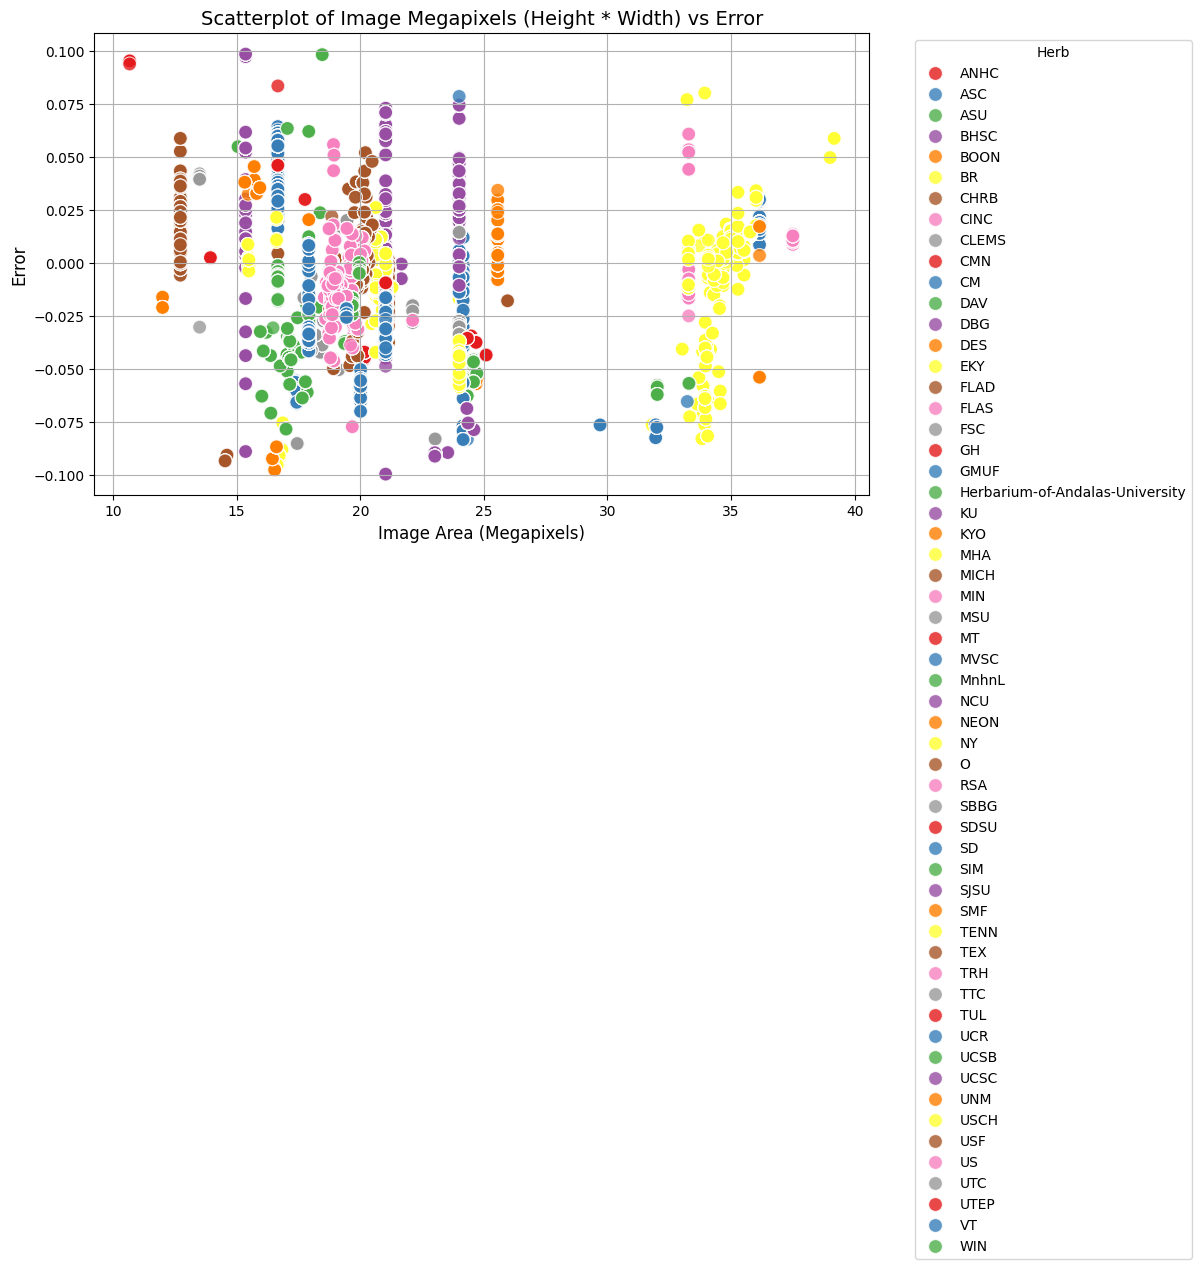

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a new column for image_area (image_height * image_width)
cleaned_df['megapixels'] = cleaned_df['image_height'] * cleaned_df['image_width'] / 1000000

# Step 2: Convert cf_error to numeric, forcing errors to NaN (this will handle empty strings)
cleaned_df['cf_error'] = pd.to_numeric(cleaned_df['cf_error'], errors='coerce')

# Step 3: Filter out rows where cf_error is NaN (invalid for plotting)
filtered_df = cleaned_df.dropna(subset=['cf_error'])

# Step 4: Set up the plot
plt.figure(figsize=(10, 6))

# Step 5: Create the scatter plot
scatter = sns.scatterplot(
    data=filtered_df,
    x='megapixels',
    y='cf_error',
    hue='herb',  # Color by herb
    palette='Set1',  # Use a color palette (optional, but Set1 works well for categories)
    s=100,  # Size of the points
    alpha=0.8  # Transparency of points
)

# Step 6: Add labels and a title
plt.title("Scatterplot of Image Megapixels (Height * Width) vs Error", fontsize=14)
plt.xlabel("Image Area (Megapixels)", fontsize=12)
plt.ylabel("Error", fontsize=12)

# Step 7: Show legend and grid
plt.legend(title='Herb', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Step 8: Display the plot
plt.tight_layout()
plt.show()


In [105]:
# Ensure cf_error is numeric, as before
cleaned_df['cf_error'] = pd.to_numeric(cleaned_df['cf_error'], errors='coerce')

# Filter rows where cf_error is greater than 2
filtered_cf_error_gt_2 = cleaned_df[cleaned_df['cf_error'] > 0.2]

# Display the rows where cf_error is greater than 2
filtered_cf_error_gt_2

Empty DataFrame
Columns: [filename, image_height, image_width, component_name, conversion_mean, predicted_conversion_factor_cm, area, perimeter, convex_hull, bbox, bbox_min, rotate_angle, bbox_min_long_side, bbox_min_short_side, efd_coeffs_features, efd_a0, efd_c0, efd_scale, efd_angle, efd_phase, efd_area, efd_perimeter, centroid, convex_hull.1, convexity, concavity, circularity, n_pts_in_polygon, aspect_ratio, polygon_closed, polygon_closed_rotated, keypoints, angle, tip, base, distance_lamina, distance_width, distance_petiole, distance_midvein_span, distance_petiole_span, trace_midvein_distance, trace_petiole_distance, apex_angle, apex_is_reflex, base_angle, base_is_reflex, to_split, component_type, component_id, herb, gbif_id, fullname, genus_species, family, genus, specific_epithet, cf_error, megapixels]
Index: []

[0 rows x 58 columns]

Now we know which leaves to use in our outline data
    - go to `outline_path` and get outlines of our leaves in cleaned_df['component_name']



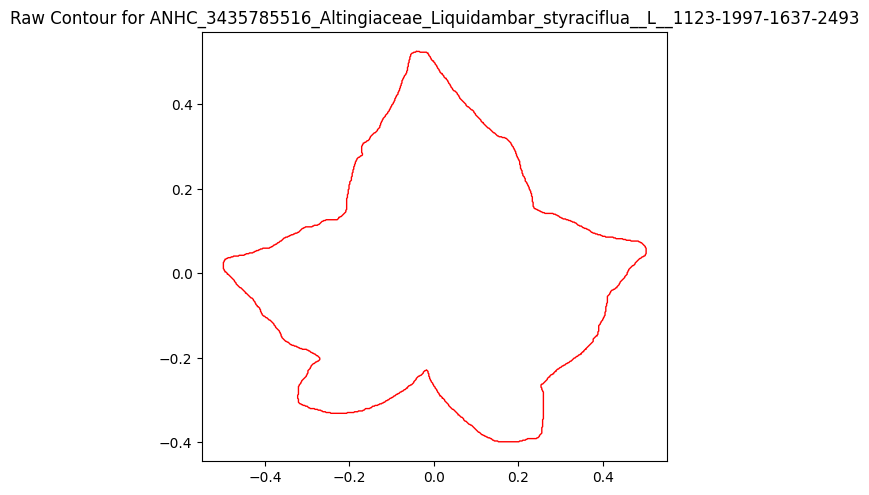

In [106]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the outline path

# Function to read and visualize the first contour without transformations
def visualize_first_contour_raw(component_name):
    # Build the path to the .txt file for the given component
    txt_file_path = os.path.join(outline_path, f'{component_name}.txt')
    
    if not os.path.exists(txt_file_path):
        print(f"File not found: {txt_file_path}")
        return
    
    # Read the data from the file
    with open(txt_file_path, 'r') as file:
        lines = file.readlines()

    # Starting from line 11, parse the points (x, y)
    points = []
    for line in lines[11:]:
        x_str, y_str = line.strip().split(',')
        x = float(x_str)
        y = float(y_str)
        points.append((x, y))

    # Convert to a NumPy array for plotting
    points_np = np.array(points, dtype=np.float32)

    # Plot the raw contour points
    plt.figure(figsize=(6, 6))
    plt.plot(points_np[:, 0], points_np[:, 1], 'r-', linewidth=1)
    plt.title(f'Raw Contour for {component_name}')
    plt.gca().set_aspect('equal', adjustable='box')  # Ensure the aspect ratio is equal
    plt.show()

# Visualize the raw contour for the first component in cleaned_df
first_component_name = cleaned_df['component_name'].iloc[0]
visualize_first_contour_raw(first_component_name)


Visualize the normalized contours based on a filter

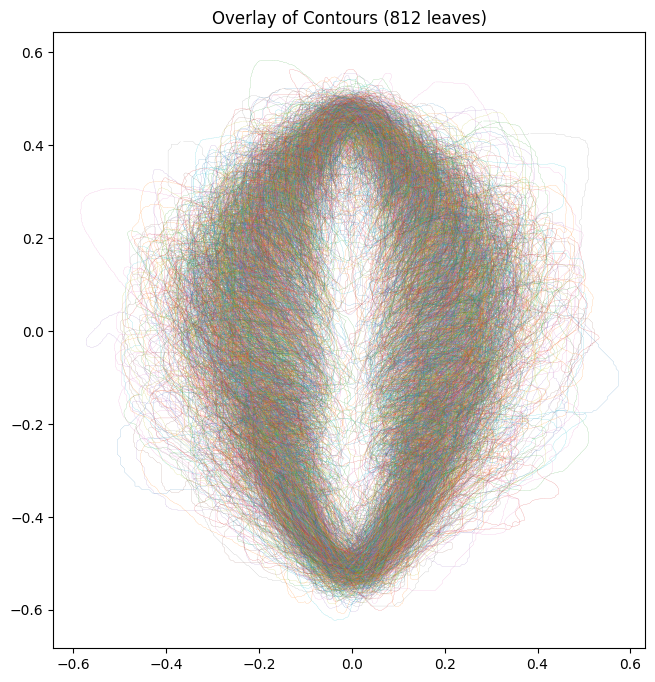

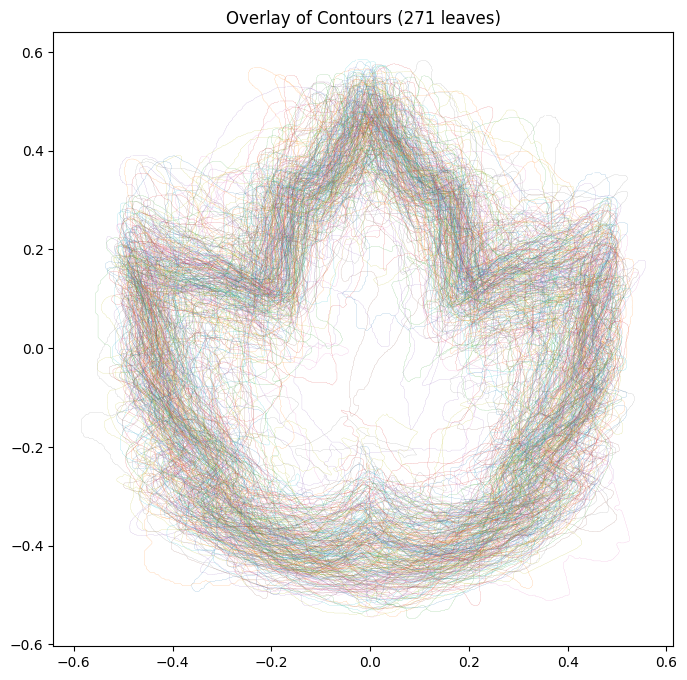

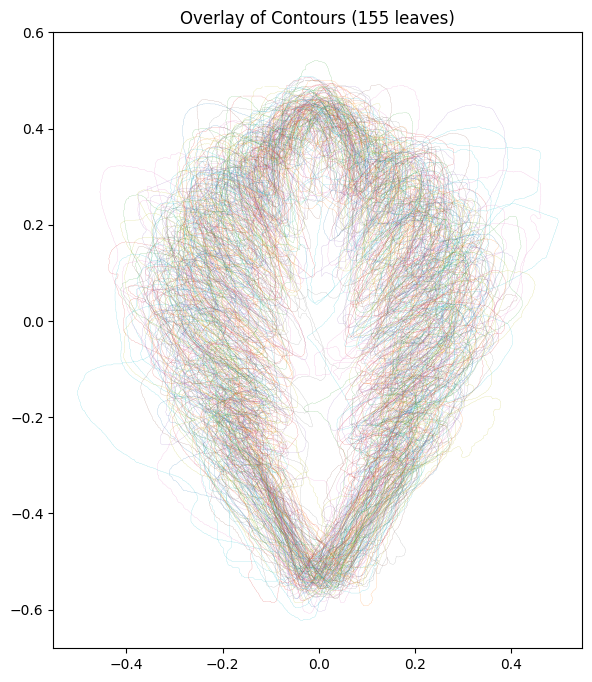

No data matches the selected filter.


In [107]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the outline path


# Function to read and overlay multiple contours
def visualize_contours_overlay(df_subset):
    plt.figure(figsize=(8, 8))
    
    # Iterate through the subset and plot each contour
    for idx, row in df_subset.iterrows():
        component_name = row['component_name']
        txt_file_path = os.path.join(outline_path, f'{component_name}.txt')
        
        if not os.path.exists(txt_file_path):
            print(f"File not found: {txt_file_path}")
            continue

        # Read the data from the file
        with open(txt_file_path, 'r') as file:
            lines = file.readlines()

        # Starting from line 11, parse the points (x, y)
        points = []
        for line in lines[11:]:
            x_str, y_str = line.strip().split(',')
            x = float(x_str)
            y = float(y_str)
            points.append((x, y))

        # Convert to a NumPy array for plotting
        points_np = np.array(points, dtype=np.float32)

        # Plot the contour points
        plt.plot(points_np[:, 0], points_np[:, 1], linewidth=0.1)

    plt.title(f'Overlay of Contours ({len(df_subset)} leaves)')
    plt.gca().set_aspect('equal', adjustable='box')  # Ensure the aspect ratio is equal
    plt.show()

# Function to filter cleaned_df based on user input and visualize
def overlay_outlines_by_filter(cleaned_df, family=None, genus=None, genus_species=None, fullname=None):
    df_subset = cleaned_df.copy()

    # Apply filtering based on input parameters
    if family:
        df_subset = df_subset[df_subset['family'] == family]
    if genus:
        df_subset = df_subset[df_subset['genus'] == genus]
    if genus_species:
        df_subset = df_subset[df_subset['genus_species'] == genus_species]
    if fullname:
        df_subset = df_subset[df_subset['fullname'] == fullname]

    # Check if any rows match the filter
    if df_subset.empty:
        print("No data matches the selected filter.")
        return

    # Visualize the contours for the filtered subset
    visualize_contours_overlay(df_subset)

# Example usage: Overlay all outlines for a given family
# Replace with your desired filter (family, genus, genus_species, fullname)
# overlay_outlines_by_filter(cleaned_df, family='Amaranthaceae')

# Other possible filters:
overlay_outlines_by_filter(cleaned_df, genus='Quercus')
overlay_outlines_by_filter(cleaned_df, genus='Acer')
overlay_outlines_by_filter(cleaned_df, genus_species='Quercus_alba')
overlay_outlines_by_filter(cleaned_df, genus_species='Quercus_glauca')
# overlay_outlines_by_filter(cleaned_df, fullname='Urticaceae_Pilea_pumila')


File not found: C:/Users/Will/Downloads/GBIF_DetailedSample_50Spp/LM2_2024_09_18__07-52-47/Keypoints/Simple_Labels\CM_2859369677_Salicaceae_Populus_tremuloides__L__1909-772-2089-894.txt


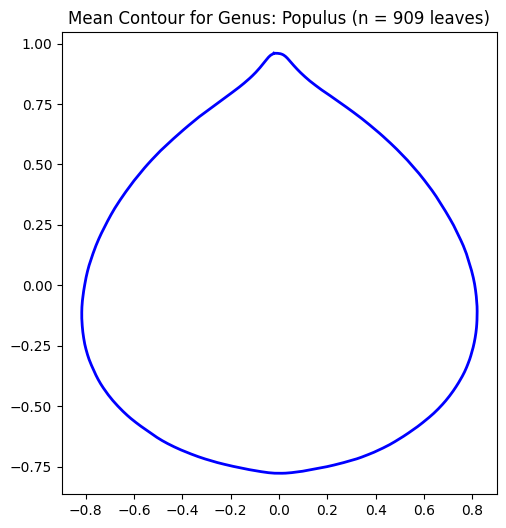

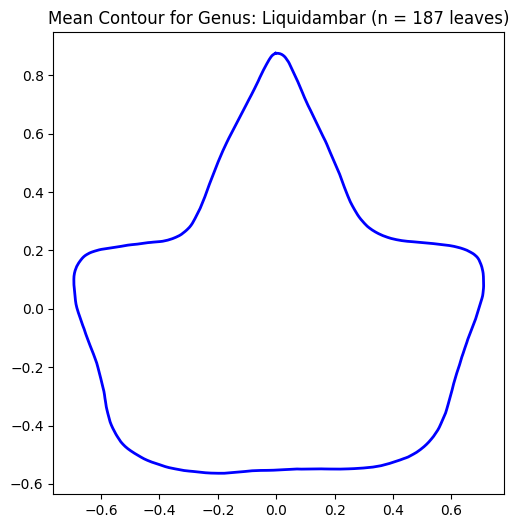

No data matches the selected filter. Genus: Liriodendron


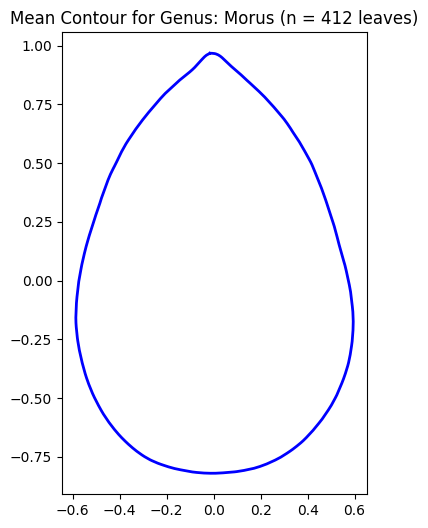

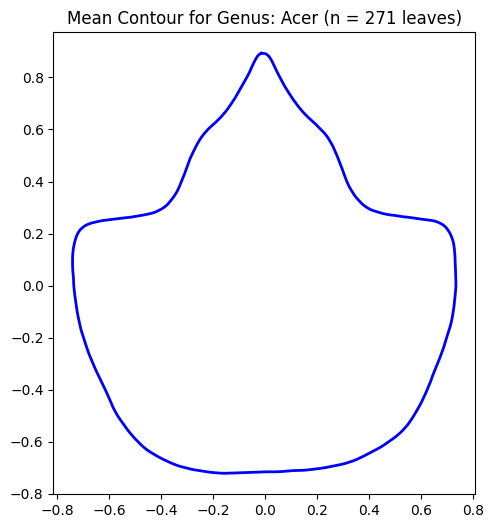

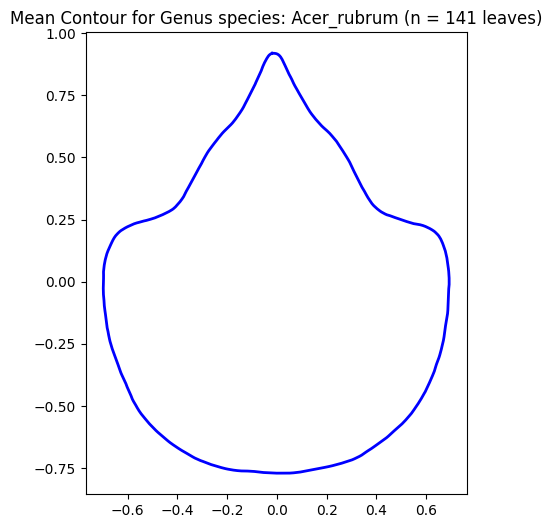

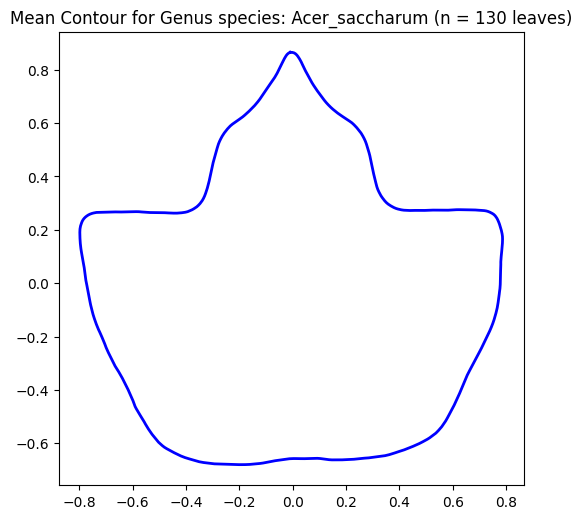

No data matches the selected filter. Genus: Salix
No data matches the selected filter. Genus species: Tussilago_farfara
No data matches the selected filter. Family: Magnoliaceae
File not found: C:/Users/Will/Downloads/GBIF_DetailedSample_50Spp/LM2_2024_09_18__07-52-47/Keypoints/Simple_Labels\BR_1839807218_Asteraceae_Hieracium_umbellatum__L__2030-3697-2973-3829.txt


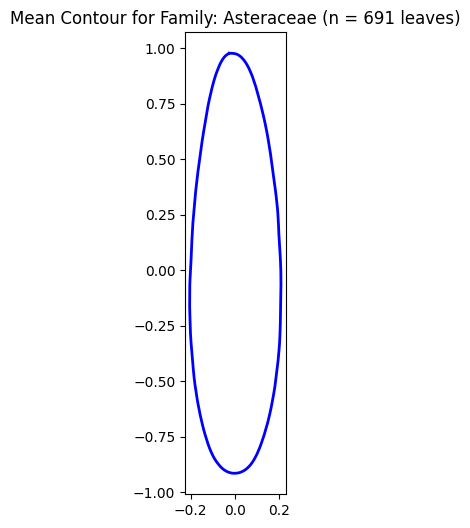

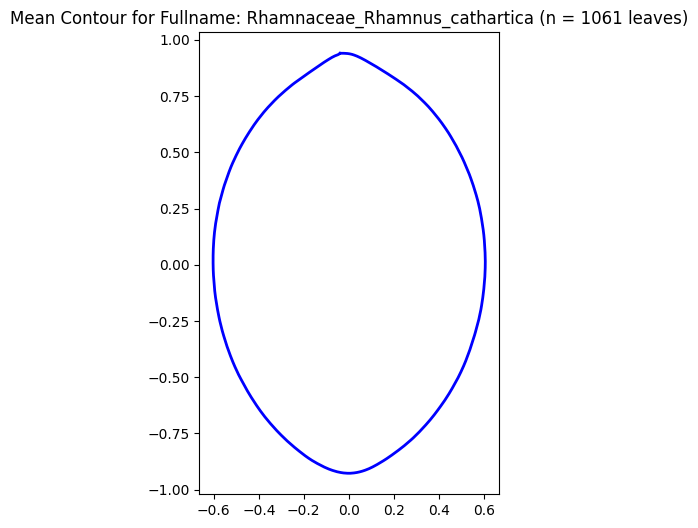

In [111]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Helper function to interpolate a contour to a fixed number of points
def interpolate_contour(points, num_points=100):
    """
    Interpolate the contour to ensure all contours have the same number of points.
    """
    # Calculate cumulative distance along the contour
    distances = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
    distances = np.insert(distances, 0, 0)  # Add the first point distance (0)

    # Interpolation functions for x and y
    interp_x = interp1d(distances, points[:, 0], kind='linear')
    interp_y = interp1d(distances, points[:, 1], kind='linear')

    # Create new distance values to interpolate
    new_distances = np.linspace(0, distances[-1], num_points)

    # Interpolate new x and y values
    new_points = np.vstack((interp_x(new_distances), interp_y(new_distances))).T

    return new_points

# Function to compute the mean contour from a filtered subset
def compute_mean_contour(df_subset, num_points=100, use_scaled=False):
    contours = []

    # Iterate through the subset and collect scaled and centered contours
    for idx, row in df_subset.iterrows():
        component_name = row['component_name']
        txt_file_path = os.path.join(outline_path, f'{component_name}.txt')

        if not os.path.exists(txt_file_path):
            print(f"File not found: {txt_file_path}")
            continue

        # Read the data from the file
        with open(txt_file_path, 'r') as file:
            lines = file.readlines()

        # Parse the max_extent and CF from the file
        max_extent = float(lines[3].strip())  # max_extent
        CF = float(lines[2].strip())  # Conversion factor (pixels per mm)

        # Use conversion_mean if available, otherwise predicted_conversion_factor_cm
        if np.isnan(row['conversion_mean']) or row['conversion_mean'] == 0:
            conversion_factor = row['predicted_conversion_factor_cm']
        else:
            conversion_factor = row['conversion_mean']

        # Starting from line 11, parse the points (x, y)
        points = []
        for line in lines[11:]:
            x_str, y_str = line.strip().split(',')
            x = float(x_str)
            y = float(y_str)
            points.append((x, y))

        # Convert to a NumPy array
        points_np = np.array(points, dtype=np.float32)

        if use_scaled:
            # Apply scaling: Multiply by max_extent, divide by conversion_factor (CF)
            points_scaled = points_np * max_extent / conversion_factor

            # Centering the points around the origin
            centroid = np.mean(points_scaled, axis=0)
            points_processed = points_scaled - centroid  # Center about the origin
        else:
            # Normalizing the points by the max extent to avoid scaling
            centroid = np.mean(points_np, axis=0)
            points_processed = points_np - centroid  # Center about the origin
            max_distance = np.max(np.linalg.norm(points_processed, axis=1))
            points_processed /= max_distance  # Normalize to unit size

        # Interpolate the contour to have a consistent number of points
        points_interpolated = interpolate_contour(points_processed, num_points=num_points)

        # Add the interpolated contour to the list
        contours.append(points_interpolated)

    # Compute the mean contour by averaging all x and y values
    mean_contour = np.mean(np.array(contours), axis=0)

    return mean_contour

# Function to plot the mean contour with additional data in the title
def plot_mean_contour(mean_contour, taxa, n):
    plt.figure(figsize=(6, 6))
    plt.plot(mean_contour[:, 0], mean_contour[:, 1], 'b-', linewidth=2)
    plt.title(f'Mean Contour for {taxa} (n = {n} leaves)')
    plt.gca().set_aspect('equal', adjustable='box')  # Ensure the aspect ratio is equal
    plt.show()

# Function to filter cleaned_df, compute mean contour, and plot with title
def compute_and_plot_mean_contour(cleaned_df, family=None, genus=None, genus_species=None, fullname=None, num_points=500, use_scaled=False):
    df_subset = cleaned_df.copy()

    # Apply filtering based on input parameters
    if family:
        df_subset = df_subset[df_subset['family'] == family]
        taxa = f"Family: {family}"
    elif genus:
        df_subset = df_subset[df_subset['genus'] == genus]
        taxa = f"Genus: {genus}"
    elif genus_species:
        df_subset = df_subset[df_subset['genus_species'] == genus_species]
        taxa = f"Genus species: {genus_species}"
    elif fullname:
        df_subset = df_subset[df_subset['fullname'] == fullname]
        taxa = f"Fullname: {fullname}"
    else:
        taxa = "Unknown taxa"

    # Check if any rows match the filter
    if df_subset.empty:
        print(f"No data matches the selected filter. {taxa}")
        return

    # Get the number of leaves
    n_leaves = len(df_subset)

    # Compute the mean contour
    mean_contour = compute_mean_contour(df_subset, num_points=num_points, use_scaled=use_scaled)

    # Plot the mean contour with additional data in the title
    plot_mean_contour(mean_contour, taxa, n_leaves)

# Example usage: Compute and plot the mean contour for a given subset
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, family='Fagaceae')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, fullname='Fagaceae_Notholithocarpus_densiflorus')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, fullname='Fagaceae_Quercus_alba')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, fullname='Fagaceae_Quercus_gambelii')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, fullname='Fagaceae_Quercus_macrocarpa')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, fullname='Fagaceae_Quercus_velutina')
# compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, fullname='Ginkgoaceae_Ginkgo_biloba')
compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus='Populus')
compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus='Liquidambar')
compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus='Liriodendron')
compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus='Morus')
compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus='Acer')
compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus_species='Acer_rubrum')
compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus_species='Acer_saccharum')
compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus='Salix')
compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, genus_species='Tussilago_farfara')
compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, family='Magnoliaceae')
compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, family='Asteraceae')
compute_and_plot_mean_contour(cleaned_df, num_points=1000, use_scaled=False, fullname='Rhamnaceae_Rhamnus_cathartica')

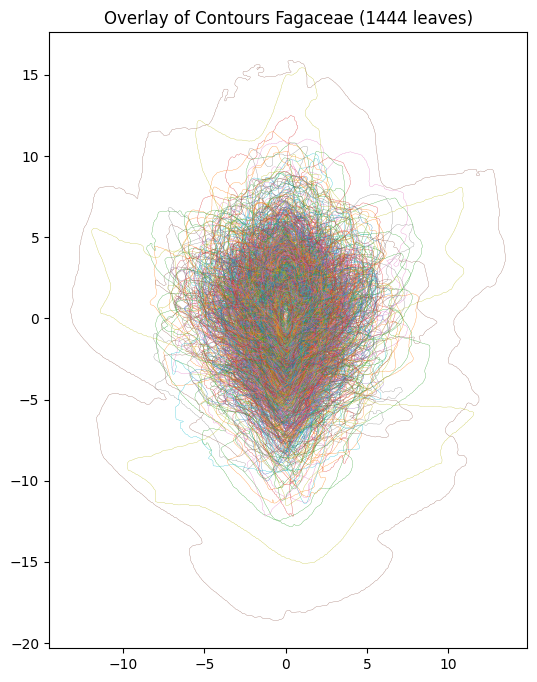

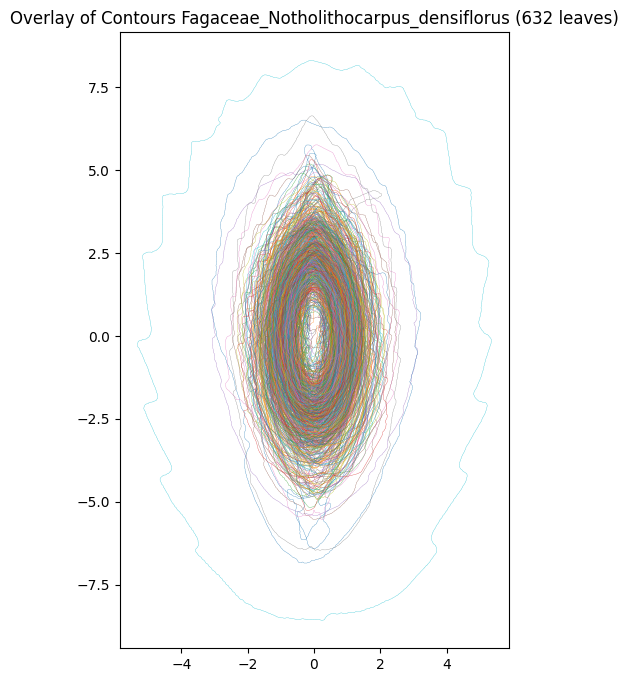

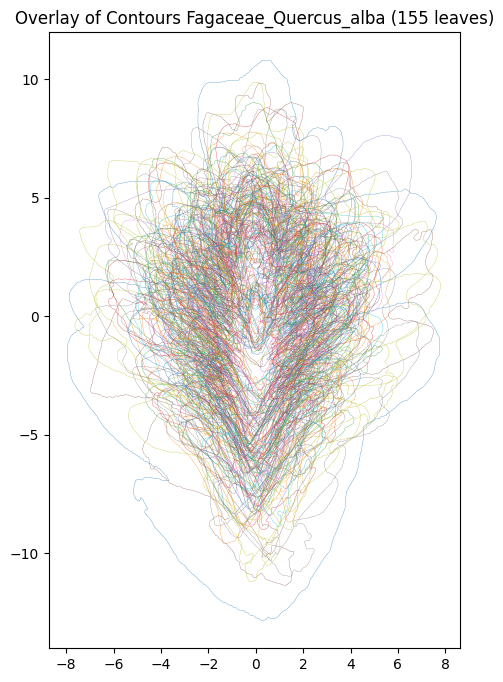

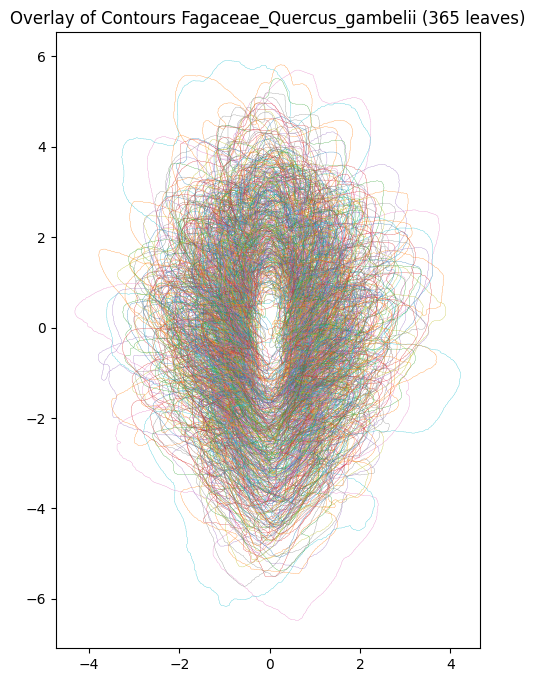

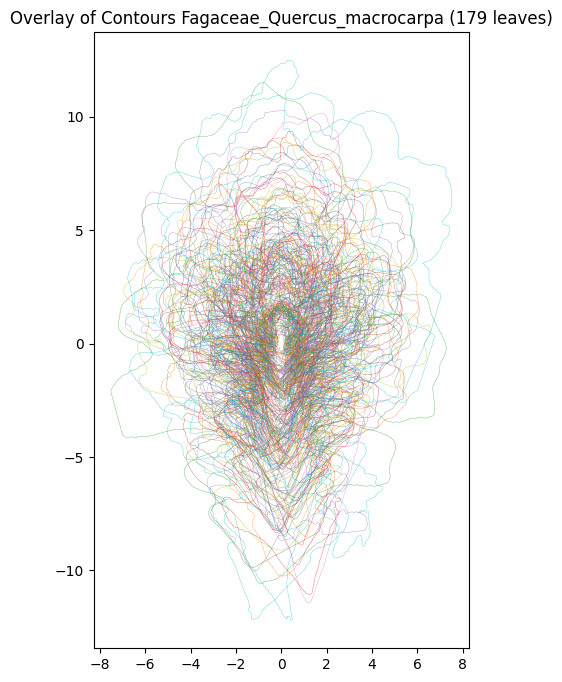

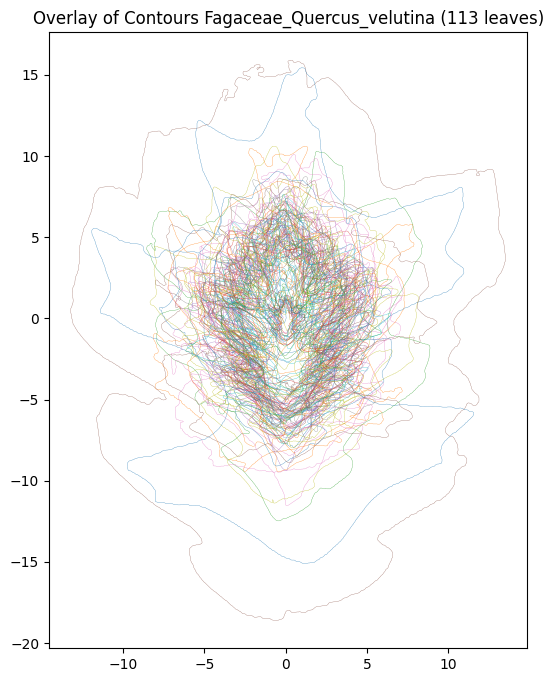

File not found: C:/Users/Will/Downloads/GBIF_DetailedSample_50Spp/LM2_2024_09_18__07-52-47/Keypoints/Simple_Labels\BOON_1844413105_Ginkgoaceae_Ginkgo_biloba__L__2307-3444-3305-4430.txt
File not found: C:/Users/Will/Downloads/GBIF_DetailedSample_50Spp/LM2_2024_09_18__07-52-47/Keypoints/Simple_Labels\SFV_2575150283_Ginkgoaceae_Ginkgo_biloba__L__537-2437-1236-2930.txt
File not found: C:/Users/Will/Downloads/GBIF_DetailedSample_50Spp/LM2_2024_09_18__07-52-47/Keypoints/Simple_Labels\SFV_2575150283_Ginkgoaceae_Ginkgo_biloba__L__920-2475-1289-3471.txt


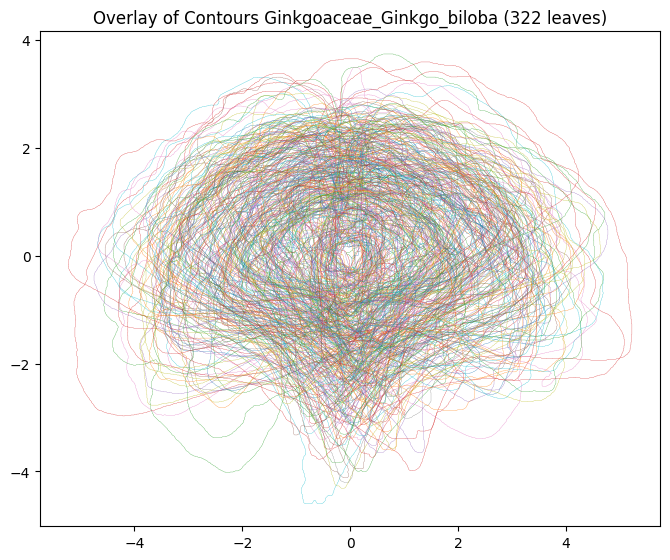

File not found: C:/Users/Will/Downloads/GBIF_DetailedSample_50Spp/LM2_2024_09_18__07-52-47/Keypoints/Simple_Labels\CM_2859369677_Salicaceae_Populus_tremuloides__L__1909-772-2089-894.txt


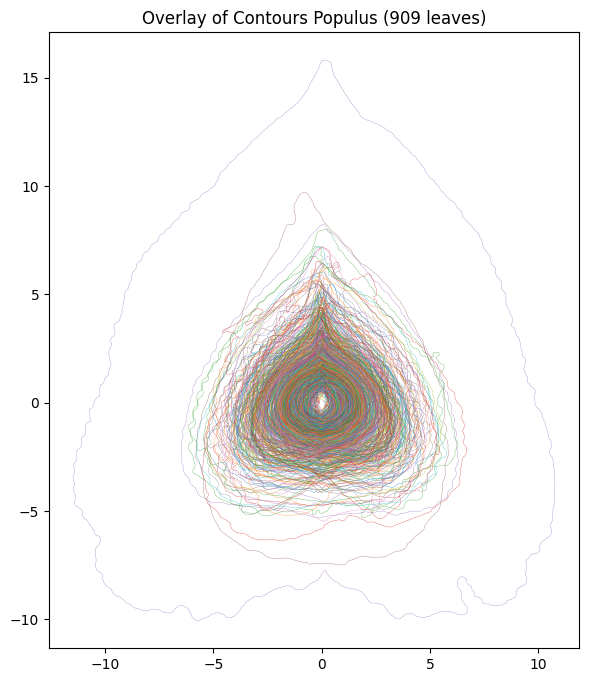

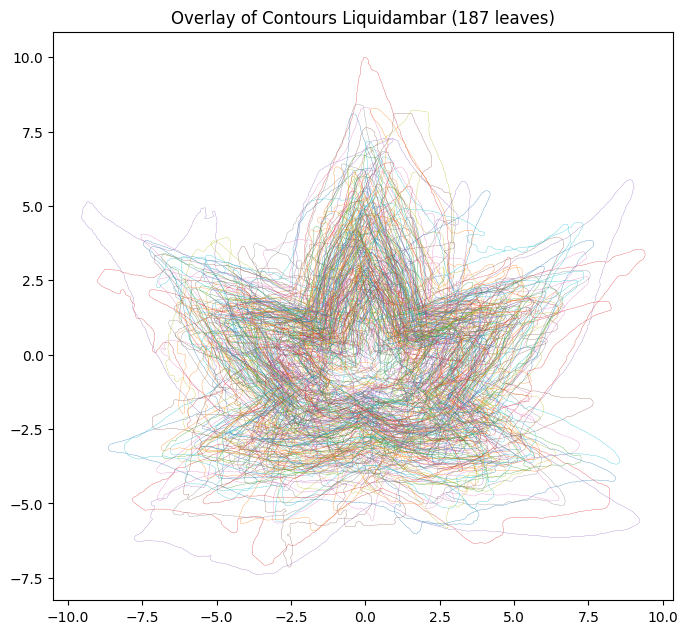

No data matches the selected filter.


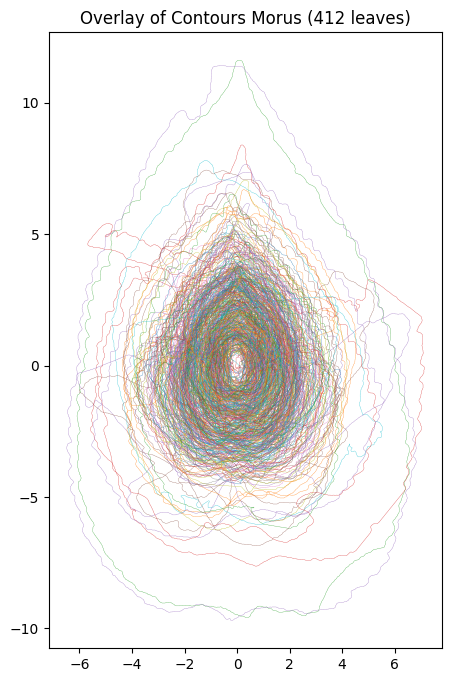

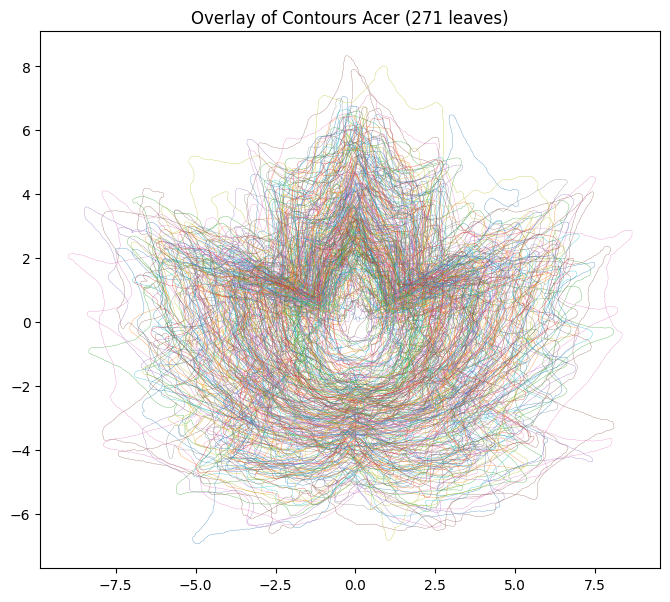

No data matches the selected filter.
No data matches the selected filter.
No data matches the selected filter.
File not found: C:/Users/Will/Downloads/GBIF_DetailedSample_50Spp/LM2_2024_09_18__07-52-47/Keypoints/Simple_Labels\BR_1839807218_Asteraceae_Hieracium_umbellatum__L__2030-3697-2973-3829.txt


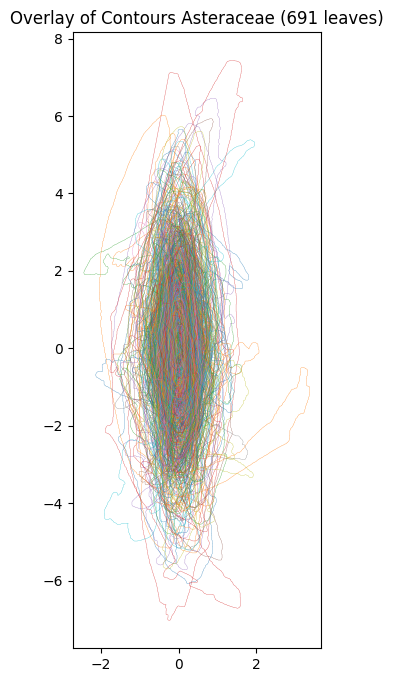

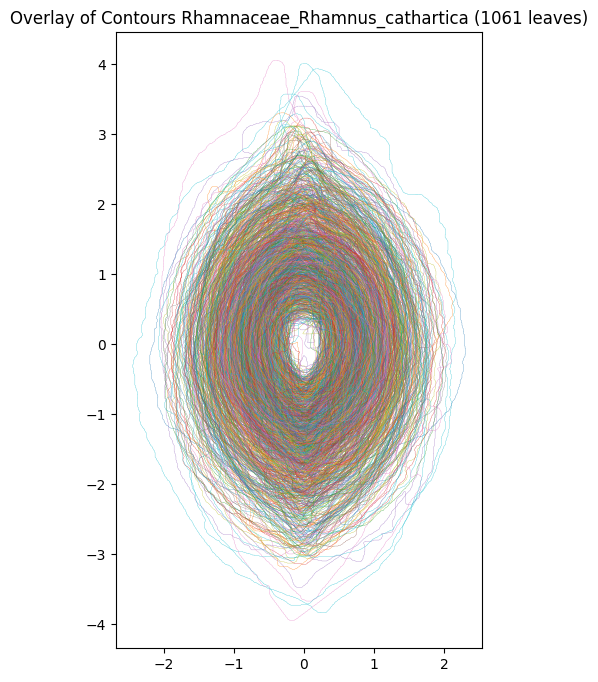

In [109]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the outline path

# Function to read and overlay multiple contours with scaling based on conversion_mean or predicted_conversion_factor_cm
def visualize_contours_overlay_scaled(df_subset, title_name):
    plt.figure(figsize=(8, 8))
    
    # Iterate through the subset and plot each contour
    for idx, row in df_subset.iterrows():
        component_name = row['component_name']
        txt_file_path = os.path.join(outline_path, f'{component_name}.txt')
        
        if not os.path.exists(txt_file_path):
            print(f"File not found: {txt_file_path}")
            continue

        # Read the data from the file
        with open(txt_file_path, 'r') as file:
            lines = file.readlines()

        # Parse the max_extent and CF from the file
        max_extent = float(lines[3].strip())  # max_extent
        CF = float(lines[2].strip())  # Conversion factor (pixels per mm)

        # Use conversion_mean if available, otherwise predicted_conversion_factor_cm
        if np.isnan(row['conversion_mean']) or row['conversion_mean'] == 0:
            conversion_factor = row['predicted_conversion_factor_cm']
        else:
            conversion_factor = row['conversion_mean']
        # print(conversion_factor)

        # Starting from line 11, parse the points (x, y)
        points = []
        for line in lines[11:]:
            x_str, y_str = line.strip().split(',')
            x = float(x_str)
            y = float(y_str)
            points.append((x, y))

        # Convert to a NumPy array for scaling and centering
        points_np = np.array(points, dtype=np.float32)

        # Apply scaling: Multiply by max_extent, divide by conversion_factor (CF)
        points_scaled = points_np * max_extent / conversion_factor

        # Centering the points around the origin
        centroid = np.mean(points_scaled, axis=0)
        points_scaled_centered = points_scaled - centroid  # Center about the origin

        # Plot the scaled and centered contour points
        plt.plot(points_scaled_centered[:, 0], points_scaled_centered[:, 1], linewidth=0.2)

    plt.title(f'Overlay of Contours {title_name} ({len(df_subset)} leaves)')
    plt.gca().set_aspect('equal', adjustable='box')  # Ensure the aspect ratio is equal
    plt.show()

# Function to filter cleaned_df based on user input and visualize
def overlay_outlines_by_filter_scaled(cleaned_df, family=None, genus=None, genus_species=None, fullname=None):
    df_subset = cleaned_df.copy()
    title_name = None

    # Apply filtering based on input parameters
    if family:
        df_subset = df_subset[df_subset['family'] == family]
        title_name = family
    if genus:
        df_subset = df_subset[df_subset['genus'] == genus]
        title_name = genus
    if genus_species:
        df_subset = df_subset[df_subset['genus_species'] == genus_species]
        title_name = genus_species
    if fullname:
        df_subset = df_subset[df_subset['fullname'] == fullname]
        title_name = fullname

    # Check if any rows match the filter
    if df_subset.empty:
        print("No data matches the selected filter.")
        return

    # Visualize the contours for the filtered subset
    visualize_contours_overlay_scaled(df_subset, title_name)

# Example usage: Overlay all outlines for a given filter
# overlay_outlines_by_filter_scaled(cleaned_df, genus='Populus')
# overlay_outlines_by_filter_scaled(cleaned_df, genus='Morus')
# overlay_outlines_by_filter_scaled(cleaned_df, genus='Quercus')
# overlay_outlines_by_filter_scaled(cleaned_df, genus='Acer')
# overlay_outlines_by_filter_scaled(cleaned_df, genus_species='Quercus_alba')
# overlay_outlines_by_filter_scaled(cleaned_df, genus_species='Quercus_glauca')
# overlay_outlines_by_filter_scaled(cleaned_df, family='Asteraceae')

overlay_outlines_by_filter_scaled(cleaned_df, family='Fagaceae')
overlay_outlines_by_filter_scaled(cleaned_df, fullname='Fagaceae_Notholithocarpus_densiflorus')
overlay_outlines_by_filter_scaled(cleaned_df, fullname='Fagaceae_Quercus_alba')
overlay_outlines_by_filter_scaled(cleaned_df, fullname='Fagaceae_Quercus_gambelii')
overlay_outlines_by_filter_scaled(cleaned_df, fullname='Fagaceae_Quercus_macrocarpa')
overlay_outlines_by_filter_scaled(cleaned_df, fullname='Fagaceae_Quercus_velutina')
overlay_outlines_by_filter_scaled(cleaned_df, fullname='Ginkgoaceae_Ginkgo_biloba')
overlay_outlines_by_filter_scaled(cleaned_df, genus='Populus')
overlay_outlines_by_filter_scaled(cleaned_df, genus='Liquidambar')
overlay_outlines_by_filter_scaled(cleaned_df, genus='Liriodendron')
overlay_outlines_by_filter_scaled(cleaned_df, genus='Morus')
overlay_outlines_by_filter_scaled(cleaned_df, genus='Acer')
overlay_outlines_by_filter_scaled(cleaned_df, genus='Salix')
overlay_outlines_by_filter_scaled(cleaned_df, genus_species='Tussilago_farfara')
overlay_outlines_by_filter_scaled(cleaned_df, family='Magnoliaceae')
overlay_outlines_by_filter_scaled(cleaned_df, family='Asteraceae')
overlay_outlines_by_filter_scaled(cleaned_df, fullname='Rhamnaceae_Rhamnus_cathartica')